# Generating features for use with classifiers

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import bz2
import os
import pickle
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

sys.path.append(os.path.abspath('../src'))
from fact_classification import *

2023-04-15 11:56:25.612964: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df, df_crowdsourced, df_ground_truth = data_loading(local=True)
df

,Sentence_id,Text,Speaker,Speaker_title,Speaker_party,File_id,Length,Line_number,Sentiment,Verdict
0,16,I think we've seen a deterioration of values.,George Bush,Vice President,REPUBLICAN,1988-09-25.txt,8,16,0.000000,-1
1,17,I think for a while as a nation we condoned th...,George Bush,Vice President,REPUBLICAN,1988-09-25.txt,16,17,-0.456018,-1
2,18,"For a while, as I recall, it even seems to me ...",George Bush,Vice President,REPUBLICAN,1988-09-25.txt,29,18,-0.805547,-1
3,19,"So we've seen a deterioration in values, and o...",George Bush,Vice President,REPUBLICAN,1988-09-25.txt,35,19,0.698942,-1
4,20,"We got away, we got into this feeling that val...",George Bush,Vice President,REPUBLICAN,1988-09-25.txt,15,20,0.000000,-1
...,...,...,...,...,...,...,...,...,...,...
23528,28958,He has promised a trillion dollars out of the ...,Al Gore,Vice President,DEMOCRAT,2000-10-17.txt,24,953,0.363438,1
23529,28965,(LAUGHTER) I -- there's an old high school deb...,George W. Bush,Governor,REPUBLICAN,2000-10-17.txt,23,960,-0.679982,-1
23530,29011,"Well, can I answer that?",George W. Bush,Governor,REPUBLICAN,2000-10-17.txt,5,1006,0.413020,-1
23531,29060,I look forward to the final weeks of this camp...,George W. Bush,Governor,REPUBLICAN,2000-10-17.txt,10,1055,0.625957,-1


From the data exploration stage we know that we have three NA's in the `Sentiment` column. We replace the NA's with the mean for the sentiment value for the NFS class.

In [4]:
df['Sentiment'] = df.Sentiment.fillna(df.Sentiment[df.Verdict == -1].mean())

We will use the numerical columns Length and Sentiment as features in the model training. Here we create a new dataframe to hold the features and normalize the Length values.

In [5]:
df_features = df[['Sentiment']].copy()
df_features['Length'] = (df['Length'] - df['Length'].mean()) / df['Length'].std()
df_features = df_features.astype(pd.SparseDtype(float, fill_value=0))
df_features

,Sentiment,Length
0,0.000000,-0.776577
1,-0.456018,-0.147540
2,-0.805547,0.874647
3,0.698942,1.346425
4,0.000000,-0.226169
...,...,...
23528,0.363438,0.481498
23529,-0.679982,0.402868
23530,0.413020,-1.012467
23531,0.625957,-0.619318


## TF-IDF features

We will generate TF-IDF (Term Frequency - Inverse Document Frequency) tokens for the raw text, then on cleaned and stemmed text, as well as on POS-tags and NER-labels. We will later use various combinations of these tokens to see how they affect the classifier models.

### Raw text, N-gram=1

First, we generate TF-IDF tokens on the raw Text column without any pre-processing. We split the dataset into training and testing in order to only generate the tokens on the training dataset. This ensures that we don't include unseen data in the token generation.

In [6]:
df_train, df_test, idx_train = test_train_split(df)

train_tfid, test_tfid, vocabulary = tfid(
    train=df_train['Text'],
    test=df_test['Text'],
    n_gram_range=1
)

len(vocabulary)

10641

This has generated 10641 distinct tokens. We then add these tokens as features in a new dataframe, being careful about keeping track of the correct indexes so that they stay identical to the original dataframe. Since this is a large sparse matrix we keep this separate from the original dataframe so that we can use the Pandas SparseDtype datatype.

In [7]:
df_features = df_features.join(
    pd.concat([
        pd.DataFrame(train_tfid.toarray(), columns='W1_' + vocabulary, index=df.index[idx_train]),
        pd.DataFrame(test_tfid.toarray(), columns='W1_' + vocabulary, index=df.index[~idx_train])
    ]).astype(pd.SparseDtype(float, fill_value=0))
)

In [8]:
df_features

,Sentiment,Length,W1_00,W1_000,W1_10,W1_100,W1_1000,W1_101,W1_104,W1_105,...,W1_zamaria,W1_zane,W1_zarqawi,W1_zemin,W1_zero,W1_zippo,W1_zone,W1_zones,W1_ãƒâ,W1_šâ
0,0.000000,-0.776577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.456018,-0.147540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.805547,0.874647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.698942,1.346425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,-0.226169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23528,0.363438,0.481498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23529,-0.679982,0.402868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23530,0.413020,-1.012467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23531,0.625957,-0.619318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df_features.dtypes

Sentiment    Sparse[float64, 0]
Length       Sparse[float64, 0]
W1_00        Sparse[float64, 0]
W1_000       Sparse[float64, 0]
W1_10        Sparse[float64, 0]
                    ...        
W1_zippo     Sparse[float64, 0]
W1_zone      Sparse[float64, 0]
W1_zones     Sparse[float64, 0]
W1_ãƒâ       Sparse[float64, 0]
W1_šâ        Sparse[float64, 0]
Length: 10643, dtype: object

### Raw text, N-gram=2

Then, we also create TF-IDF based on the raw text using N-gram=2. This may capture a little more of the context in the sentences.

In [10]:
train_tfid, test_tfid, vocabulary = tfid(
    train=df_train['Text'],
    test=df_test['Text'],
    n_gram_range=2,
    max_features=10000
)

len(vocabulary)

10000

Here, we limit the number of tokens to 10000 to avoid too large sparse matrix.

In [11]:
df_features = df_features.join(
    pd.concat([
        pd.DataFrame(train_tfid.toarray(), columns='W2_' + vocabulary, index=df.index[idx_train]),
        pd.DataFrame(test_tfid.toarray(), columns='W2_' + vocabulary, index=df.index[~idx_train])
    ]).astype(pd.SparseDtype(float, fill_value=0))
)

In [12]:
df_features

,Sentiment,Length,W1_00,W1_000,W1_10,W1_100,W1_1000,W1_101,W1_104,W1_105,...,W2_your money,W2_your own,W2_your plan,W2_your pocket,W2_your president,W2_your question,W2_your support,W2_your tax,W2_your taxes,W2_your vote
0,0.000000,-0.776577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.456018,-0.147540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.805547,0.874647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.698942,1.346425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,-0.226169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23528,0.363438,0.481498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23529,-0.679982,0.402868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23530,0.413020,-1.012467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23531,0.625957,-0.619318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
df_features.dtypes

Sentiment           Sparse[float64, 0]
Length              Sparse[float64, 0]
W1_00               Sparse[float64, 0]
W1_000              Sparse[float64, 0]
W1_10               Sparse[float64, 0]
                           ...        
W2_your question    Sparse[float64, 0]
W2_your support     Sparse[float64, 0]
W2_your tax         Sparse[float64, 0]
W2_your taxes       Sparse[float64, 0]
W2_your vote        Sparse[float64, 0]
Length: 20643, dtype: object

### Cleaned and stemmed text

Next, we clean the text by converting to lowercase, removing stopwords, punctuations and newlines.

In [14]:
df = clean_text(df, column='Text')
df['cleaned_text'].head()

0                 think weve seen deterioration values
1               think nation condoned things condemned
2    while recall even seems talk legalizing decrim...
3    weve seen deterioration values one things thin...
4      got away got feeling value free education thing
Name: cleaned_text, dtype: object

Next, we perform stemming on the cleaned text.

In [15]:
df['stemmed'] = stem(df, column='cleaned_text')
df['stemmed'].head()

0                        think weve seen deterior valu
1                    think nation condon thing condemn
2    while recal even seem talk legal decrimin mari...
3    weve seen deterior valu one thing think term c...
4               got away got feel valu free educ thing
Name: stemmed, dtype: object

Finally, we generate tokens based on the stemmed text.

In [16]:
df_train, df_test, idx_train = test_train_split(df)

train_tfid, test_tfid, vocabulary = tfid(
    train=df_train['stemmed'],
    test=df_test['stemmed'],
    n_gram_range=1
)

len(vocabulary)

7537

This has generated 7537 distinct tokens. We then add these as features in the dataframe.

In [17]:
df_features = df_features.join(
    pd.concat([
        pd.DataFrame(train_tfid.toarray(), columns='WS_' + vocabulary, index=df.index[idx_train]),
        pd.DataFrame(test_tfid.toarray(), columns='WS_' + vocabulary, index=df.index[~idx_train])
    ]).astype(pd.SparseDtype(float, fill_value=0))
)

In [18]:
df_features

,Sentiment,Length,W1_00,W1_000,W1_10,W1_100,W1_1000,W1_101,W1_104,W1_105,...,WS_zamaria,WS_zane,WS_zarqawi,WS_zemin,WS_zero,WS_zerobas,WS_zippo,WS_zone,WS_ãƒâ,WS_šâ
0,0.000000,-0.776577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.456018,-0.147540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.805547,0.874647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.698942,1.346425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,-0.226169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23528,0.363438,0.481498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23529,-0.679982,0.402868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23530,0.413020,-1.012467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23531,0.625957,-0.619318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## POS-tagging

Now, we will add Part-of-Speech tags to the features.

In [19]:
df['POS'] = get_pos_tags(df['Text'])
df['POS'].head()

0                         PRP VBP PRP VBN DT NN IN NNS
1    PRP VBP IN DT NN IN DT NN PRP VBD DT NNS PRP M...
2    IN DT NN IN PRP VBP PRP RB VBZ TO PRP IN EX VB...
3    IN PRP VBN DT NN IN NNS CC CD IN DT NNS WDT PR...
4      PRP VBD RB PRP VBD IN DT NN WDT JJ NN VBD DT NN
Name: POS, dtype: object

In [20]:
df_train, df_test, idx_train = test_train_split(df)

train_tfid, test_tfid, vocabulary = tfid(
    train=df_train['POS'],
    test=df_test['POS'],
    n_gram_range=1
)

len(vocabulary)

31

In [21]:
vocab_count = train_tfid.astype(bool).sum(axis=0).tolist()[0]

We see that we have 31 POS tags in the corpus.

In [22]:
vocabulary = np.char.upper(vocabulary.astype('U')).astype(np.object_)
vocabulary

array(['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'MD', 'NN',
       'NNP', 'NNPS', 'NNS', 'PDT', 'PRP', 'RB', 'RBR', 'RBS', 'RP', 'TO',
       'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WRB'],
      dtype=object)

In [23]:
df_pos_plot = pd.DataFrame({'POS': vocabulary, 'Count': vocab_count})

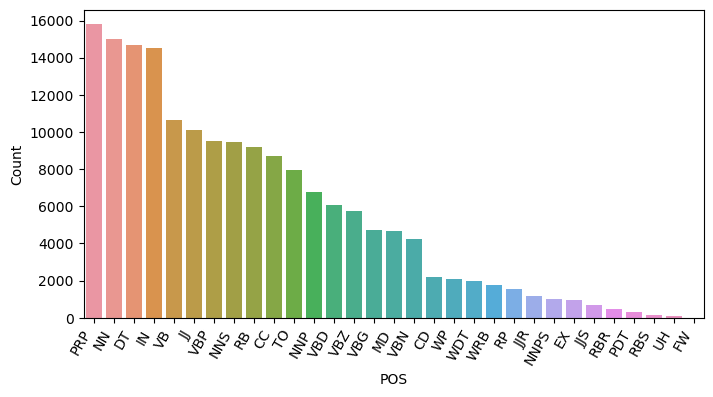

In [24]:
fig = plt.figure(figsize=(8, 4))
sns.barplot(data=df_pos_plot, x='POS', y='Count', order=df_pos_plot.sort_values('Count', ascending=False)['POS'])
plt.xticks(rotation=60, ha='right')
plt.ylabel('Count')
plt.show()

Add the POS-tags to the feature matrix.

In [25]:
df_features = df_features.join(
    pd.concat([
        pd.DataFrame(train_tfid.toarray(), columns='P_' + vocabulary, index=df.index[idx_train]),
        pd.DataFrame(test_tfid.toarray(), columns='P_' + vocabulary, index=df.index[~idx_train])
    ]).astype(pd.SparseDtype(float, fill_value=0))
)

In [26]:
df_features

,Sentiment,Length,W1_00,W1_000,W1_10,W1_100,W1_1000,W1_101,W1_104,W1_105,...,P_UH,P_VB,P_VBD,P_VBG,P_VBN,P_VBP,P_VBZ,P_WDT,P_WP,P_WRB
0,0.000000,-0.776577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.535821,0.358341,0.000000,0.000000,0.0,0.0
1,-0.456018,-0.147540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.197264,0.269569,0.000000,0.316522,0.211681,0.000000,0.000000,0.0,0.0
2,-0.805547,0.874647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.159802,0.178578,0.000000,0.250971,0.163968,0.000000,0.0,0.0
3,0.698942,1.346425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.176212,0.000000,0.000000,0.141371,0.094545,0.123539,0.184132,0.0,0.0
4,0.000000,-0.226169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.700583,0.000000,0.000000,0.000000,0.000000,0.357141,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23528,0.363438,0.481498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.241805,0.000000,0.184630,0.193995,0.000000,0.169525,0.000000,0.0,0.0
23529,-0.679982,0.402868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.270976,0.000000,0.206903,0.000000,0.000000,0.189976,0.283154,0.0,0.0
23530,0.413020,-1.012467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.416911,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
23531,0.625957,-0.619318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.334222,0.000000,0.000000,0.0,0.0


## NER-Labels

We also add Named Entity Recognition labels to the feature matrix.

In [27]:
df['NER'] = ner_labels(df['Text'])
df['NER'].head()

0            
1            
2         ORG
3    CARDINAL
4            
Name: NER, dtype: object

In [28]:
df_train, df_test, idx_train = test_train_split(df)

train_tfid, test_tfid, vocabulary = tfid(
    train=df_train['NER'],
    test=df_test['NER'],
    n_gram_range=1
)

len(vocabulary)

18

In [29]:
vocab_count = train_tfid.astype(bool).sum(axis=0).tolist()[0]

Here we see that we have 18 NER labels in the corpus. We add them to our feature matrix.

In [30]:
df_features = df_features.join(
    pd.concat([
        pd.DataFrame(train_tfid.toarray(), columns='E_' + vocabulary, index=df.index[idx_train]),
        pd.DataFrame(test_tfid.toarray(), columns='E_' + vocabulary, index=df.index[~idx_train])
    ]).astype(pd.SparseDtype(float, fill_value=0))
)

df_features

,Sentiment,Length,W1_00,W1_000,W1_10,W1_100,W1_1000,W1_101,W1_104,W1_105,...,E_money,E_norp,E_ordinal,E_org,E_percent,E_person,E_product,E_quantity,E_time,E_work_of_art
0,0.000000,-0.776577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.456018,-0.147540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.805547,0.874647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.698942,1.346425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,-0.226169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23528,0.363438,0.481498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.798661,0.0,0.0,0.601781,0.0,0.0,0.0,0.0,0.0,0.0
23529,-0.679982,0.402868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
23530,0.413020,-1.012467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
23531,0.625957,-0.619318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
vocabulary = np.char.upper(vocabulary.astype('U')).astype(np.object_)
vocabulary

array(['CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW',
       'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON',
       'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART'], dtype=object)

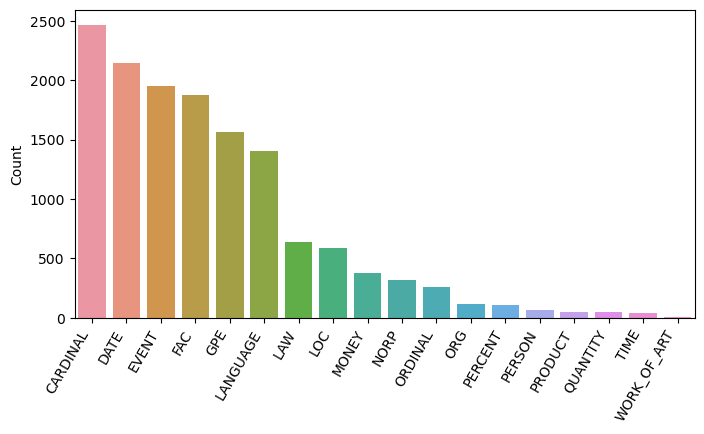

In [32]:
fig = plt.figure(figsize=(8, 4))
sns.barplot(x=vocabulary, y=vocab_count, order=vocab_count.sort(reverse=True))
plt.xticks(rotation=60, ha='right')
plt.ylabel('Count')
plt.show()

## Export features to file

In [33]:
with bz2.open('../results/df_features.bz2', 'wb') as f:
    pickle.dump(df_features, f)

## Correlations

In [34]:
a = df_features.copy()
corrs = a.corrwith(df['Verdict']).abs()


Top correlations

In [35]:
top_corrs = corrs[corrs > 0.15].sort_values(ascending=False)
top_corrs

P_VBD         0.291838
P_VB          0.270290
E_money       0.228549
P_CD          0.200914
P_NNP         0.193264
E_percent     0.190689
P_VBP         0.185776
E_cardinal    0.182898
E_date        0.182019
Length        0.177815
P_MD          0.161424
Sentiment     0.161347
W1_billion    0.160426
W1_percent    0.159880
WS_billion    0.159615
WS_percent    0.159563
P_PRP         0.153621
WS_year       0.151998
P_IN          0.150969
dtype: float64

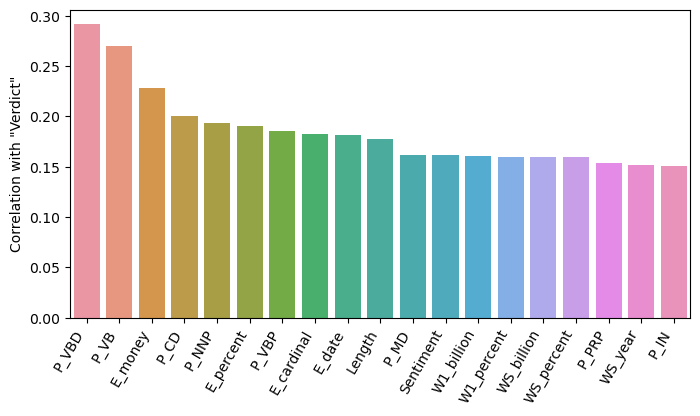

In [36]:
fig = plt.figure(figsize=(8, 4))
sns.barplot(x=top_corrs.index, y=top_corrs)
plt.xticks(rotation=60, ha='right')
plt.ylabel('Correlation with "Verdict"')
plt.show()

We notice that there is a mix of POS-tags, NER-labels and TF-IDF's, as well as the two numeric fields "Length" and "Sentiment". We also notice that the top two correlations are both verbs, and that references to numbers and time are highly represented in the top 25. Some of these does, however, seems redundant if we want to combine the different tokenizations. For example, we see that the words "percent", "million", and "billion" are all represented twice in the top 25. Another example is the P_CD and the E_cardinal tags, both representing the same thing.

In order to reduce the redundant features among the three TF-IDF methods, we remove the bigram- and stemmed features, leaving the TF-IDF on the raw text. It can be seen in the model-specific notebooks that the TF-IDF on raw text gives the best model scores.

In [37]:
idx = (df_features.columns == 'Length') | (df_features.columns == 'Sentiment') | df_features.columns.str.startswith('W1_') | df_features.columns.str.startswith('P_') | df_features.columns.str.startswith('E_')
b = df_features.loc[:, idx].copy()
corrs = b.corrwith(df['Verdict']).abs()

In [38]:
top30_corrs = corrs.sort_values(ascending=False)[:30]
top30_corrs

P_VBD         0.291838
P_VB          0.270290
E_money       0.228549
P_CD          0.200914
P_NNP         0.193264
E_percent     0.190689
P_VBP         0.185776
E_cardinal    0.182898
E_date        0.182019
Length        0.177815
P_MD          0.161424
Sentiment     0.161347
W1_billion    0.160426
W1_percent    0.159880
P_PRP         0.153621
P_IN          0.150969
P_TO          0.148141
W1_to         0.143875
W1_million    0.142658
P_VBN         0.137056
E_org         0.132386
W1_think      0.130576
W1_year       0.124232
W1_in         0.121549
W1_he         0.119350
W1_000        0.118827
W1_was        0.117285
P_NNS         0.116828
W1_said       0.115314
W1_years      0.111299
dtype: float64

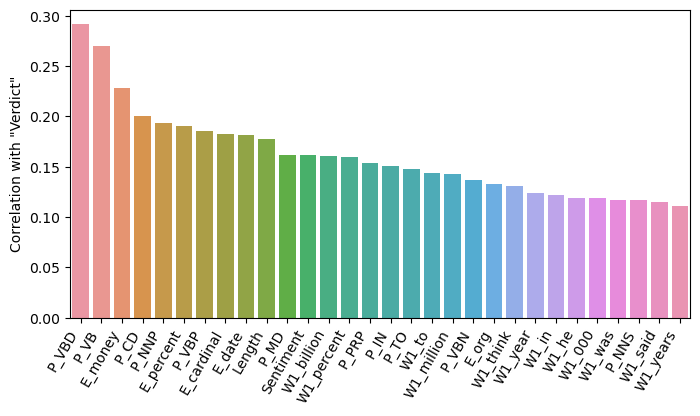

In [39]:
fig = plt.figure(figsize=(8, 4))
sns.barplot(x=top30_corrs.index, y=top30_corrs)
plt.xticks(rotation=60, ha='right')
plt.ylabel('Correlation with "Verdict"')
plt.show()

Lowest correlations

In [40]:
bottom30_corrs = corrs.sort_values(ascending=False)[-30:]
bottom30_corrs

W1_solvent            0.000057
W1_rapidly            0.000055
W1_operating          0.000055
W1_famous             0.000054
W1_secondary          0.000054
W1_mention            0.000048
W1_systems            0.000048
W1_oldest             0.000046
W1_frustration        0.000045
W1_screens            0.000043
W1_districts          0.000042
W1_conceived          0.000041
W1_artificial         0.000037
W1_participated       0.000030
W1_carefully          0.000028
W1_improvements       0.000024
W1_minimize           0.000023
W1_capability         0.000023
W1_purposes           0.000022
W1_inspection         0.000022
W1_island             0.000022
W1_anniversary        0.000019
W1_proponent          0.000018
W1_option             0.000018
W1_predicted          0.000017
W1_tasks              0.000014
W1_dragged            0.000013
W1_paycheck           0.000011
W1_grandmother        0.000011
W1_totalitarianism    0.000005
dtype: float64